In [6]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
tf.enable_eager_execution()

import os
import time
import numpy as np
import glob
import matplotlib.pyplot as plt
import PIL
import imageio
import skimage

from IPython import display
%matplotlib inline

In [2]:
tfk = tf.keras
tfkl = tf.keras.layers

In [3]:
path = '/root/nfs/kun1/users/justinvyu/data/fixed_data.pkl'
import gzip
import pickle
with gzip.open(path, 'rb') as f:
    images = pickle.load(f)

## Fixing the data

In [18]:
normalized_images, unnormalized_images = images[:300000], images[300000:]

In [19]:
normalized_images.shape, unnormalized_images.shape

((300000, 32, 32, 3), (300000, 32, 32, 3))

In [30]:
fixed_images_0 = skimage.util.img_as_ubyte(normalized_images)

In [31]:
fixed_images_1 = unnormalized_images.astype(np.uint8)

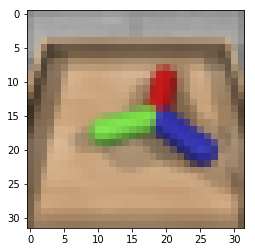

In [33]:
plt.imshow(fixed_images_0[15000])
plt.imshow(fixed_images_1[15000])

In [34]:
fixed_dataset = np.stack([fixed_images_0, fixed_images_1])

(600000, 32, 32, 3)

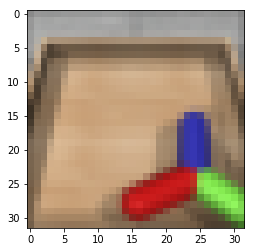

In [39]:
plt.imshow(fixed_dataset[599999])
fixed_dataset.shape

In [41]:
import gzip
import pickle
with gzip.open('/root/nfs/kun1/users/justinvyu/data/fixed_data.pkl', 'wb') as f:
    pickle.dump(fixed_dataset, f)

In [80]:
np.random.shuffle(fixed_dataset)

In [81]:
images = fixed_dataset

## Create training/eval sets

In [4]:
np.random.shuffle(images)

In [5]:
num_images = images.shape[0]
split_index = int(0.1 * num_images)
train_images = images[split_index:]
test_images = images[:split_index]

In [21]:
# Create training and test sets
BATCH_SIZE = 128

def train_generator():
    for image in train_images:
        yield image

def test_generator():
    for image in test_images:
        yield image
        
train_dataset = tf.data.Dataset.from_generator(train_generator, tf.uint8).batch(BATCH_SIZE)
test_dataset = tf.data.Dataset.from_generator(test_generator, tf.uint8).batch(BATCH_SIZE)

## Define the model

In [10]:
from softlearning.models.vae import VAE

## Create the optimizer + ELBO loss function

In [30]:
optimizer = tf.keras.optimizers.Adam(1e-4)

def log_normal_pdf(sample, mean, logvar, raxis=1):
    log2pi = tf.math.log(2. * np.pi)
    return tf.reduce_sum(
        -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
        axis=raxis)

@tf.function
def compute_loss(model, x):
    mean, logvar = model.encode(x)
    z = model.reparameterize(mean, logvar)
    x_logit = model.decode(z)

    # Cross entropy reconstruction loss assumes that the pixels
    # are all independent Bernoulli r.v.s
    # Need to preprocess the label, so the output will be normalized.
    cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(
        logits=x_logit, labels=model.preprocess(x))
    # Sum across all pixels (row/col) + channels
    logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
    
    # Calculate the KL divergence (difference between log of unit normal prior and posterior)
    logpz = log_normal_pdf(z, 0., 0.) # Prior PDF
    logqz_x = log_normal_pdf(z, mean, logvar) # Posterior
    
    reconstruction_loss = logpx_z
    kl_divergence = logpz - logqz_x
    
    beta = 1.0
    loss = reconstruction_loss + beta * kl_divergence
    
#     return -tf.reduce_mean(logpx_z + logpz - logqz_x)
    return -tf.reduce_mean(loss)

@tf.function
def compute_apply_gradients(model, x, optimizer):
    with tf.GradientTape() as tape:
        loss = compute_loss(model, x)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

In [31]:
epochs = 500
latent_dim = 16
num_examples_to_generate = 16
image_shape = (32, 32, 3)

random_vector_for_generation = tf.random.normal(
    shape=[num_examples_to_generate, latent_dim])
vae = VAE(input_shape=image_shape, latent_dim=latent_dim)

In [32]:
vae.encoder.summary()
vae.decoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_2 (Lambda)            (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 15, 15, 64)        1792      
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 7, 7, 64)          36928     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 5, 5, 32)          18464     
_________________________________________________________________
flatten_2 (Flatten)          (None, 800)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)                25632     
Total params: 82,816
Trainable params: 82,816
Non-trainable params: 0
_______________________________________________________

## Visualization

In [7]:
def plot_images(images, title=''):
    num_images = images.shape[0]
    rows = int(np.sqrt(num_images))
    cols = num_images // rows
    plt.figure(figsize=(rows, cols))
    plt.title(title)
    print(title)
    for i in range(num_images):
        plt.subplot(rows, cols, i + 1)
        plt.axis('off')
        plt.imshow(images[i, ...])
    plt.show()

def generate_and_save_images(model, epoch, test_input):
    predictions = model.sample(test_input)
    fig = plt.figure(figsize=(4,4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, :])
        plt.axis('off')

    plt.savefig('/root/softlearning/softlearning/scripts/vae_images/image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

## Training loop

In [ ]:
generate_and_save_images(vae, 0, random_vector_for_generation)
elbo_history = []

for epoch in range(1, epochs + 1):
    start_time = time.time()
    for train_x in train_dataset:
        compute_apply_gradients(vae, train_x, optimizer)
    end_time = time.time()

    if epoch % 25 == 0:
        # Save weights
        vae.encoder.save_weights('/root/softlearning/softlearning/scripts/invisible_claw_encoder_weights.h5')
        vae.decoder.save_weights('/root/softlearning/softlearning/scripts/invisible_claw_decoder_weights.h5')

    if epoch % 1 == 0:
        loss = tf.keras.metrics.Mean()
        for test_x in test_dataset:
            loss(compute_loss(vae, test_x))
        elbo = -loss.result()
        display.clear_output(wait=False)
        print('Epoch: {}, Test set ELBO: {}, '
              'time elapse for current epoch {}'.format(epoch, elbo, end_time - start_time))
        elbo_history.append(elbo)
        generate_and_save_images(
            vae, epoch, random_vector_for_generation)

## Visualizing ground truth vs. reconstructions

Ground truth images


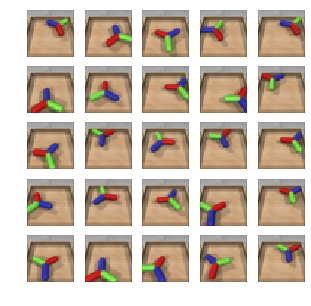

VAE Reconstructions


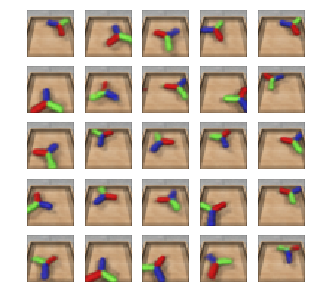

In [63]:
n = 25
eval_images = test_images[:n]
plot_images(eval_images, title='Ground truth images')
reconstructions = vae(eval_images)
plot_images(np.array(reconstructions), title='VAE Reconstructions')

## Test loading a model

In [11]:
loaded_vae = VAE(image_shape=(32, 32, 3), latent_dim=16)
encoder_path = '/root/softlearning/softlearning/models/vae_weights/invisible_claw_encoder_weights.h5'
decoder_path = '/root/softlearning/softlearning/models/vae_weights/invisible_claw_decoder_weights.h5'
loaded_vae.encoder.load_weights(encoder_path)
loaded_vae.decoder.load_weights(decoder_path)
loaded_reconstructions = loaded_vae(eval_images)
plot_images(np.array(loaded_reconstructions), title='Loaded VAE Reconstructions')
loaded_encodings = loaded_vae.encode(eval_images)

NameError: name 'eval_images' is not defined

In [5]:
loaded_vae.get_encoder()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 64)        1792      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 7, 7, 64)          36928     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 5, 5, 32)          18464     
_________________________________________________________________
flatten_1 (Flatten)          (None, 800)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                25632     
_________________________________________________________________
lambda_2 (Lambda)            (None, 16)                0   

In [2]:
from softlearning.environments.adapters.gym_adapter import GymAdapter
import numpy as np
env = GymAdapter('DClaw', 'TurnFreeValve3Fixed-v0', **{
    'camera_settings': {
        'azimuth': 180,
        'distance': 0.35,
        'elevation': -55,
        'lookat': (0, 0, 0.03),
    },
    'pixel_wrapper_kwargs': {
        'pixels_only': False,
        'normalize': False,
        'render_kwargs': {
            'camera_id': -1,
            'width': 32,
            'height': 32
        }
    },
    'observation_keys': (
        'claw_qpos',
        'last_action',
        'pixels',
        'object_xy_position',
        'object_z_orientation_cos',
        'object_z_orientation_sin',
        'target_xy_position',
        'target_z_orientation_cos',
        'target_z_orientation_sin',
    ),
    'init_qpos_range': (
        (-0.025, -0.025, 0, 0, 0, -np.pi),
        (0.025, 0.025, 0, 0, 0, np.pi)
    ),
    'target_qpos_range': [(0, 0, 0, 0, 0, np.pi)],
})

/opt/conda/envs/vice/lib/python3.7/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [38]:
for i in range(100):
    obs, _, _, _ = env.step(np.random.uniform(-1, 1, size=9))

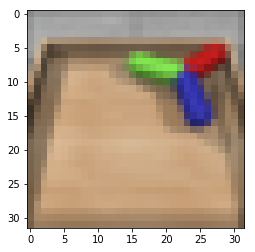

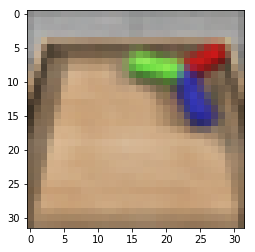

In [39]:
plt.imshow(obs['pixels'])
plt.show()
plt.imshow(np.array(loaded_vae(obs['pixels'][None]))[0])
plt.show()